# Embedding Political Subreddits Over Time

In [1]:
import findspark
findspark.init("/h/224/cameron/spark-3.0.0-preview2-bin-hadoop2.7")
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tempfile

In [2]:
spark = SparkSession.builder.getOrCreate()
spark.sparkContext.getConf().getAll()

[('spark.driver.host', 'adavm1.ais.sandbox'),
 ('spark.driver.memory', '350g'),
 ('spark.driver.port', '34707'),
 ('spark.app.id', 'local-1591835951508'),
 ('spark.shuffle.memoryFraction', '0.8'),
 ('spark.executor.id', 'driver'),
 ('spark.executor.memory', '350g'),
 ('spark.app.name', 'PySparkShell'),
 ('spark.sql.shuffle.partitions', '32'),
 ('spark.default.parallelism', '50'),
 ('spark.local.dir', '/h/224/cameron/SPARK-LOCAL-DIR'),
 ('spark.sql.catalogImplementation', 'hive'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.driver.maxResultSize', '0'),
 ('spark.executor.cores', '16'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.storage.memoryFraction', '0.05')]

In [ ]:
# Load the Parquet data
comments = spark.read.load("/comments_2019.parquet").fillna("")
comments.createOrReplaceTempView("comments")
political_subreddits = tuple(["JoeBiden","Pete_Buttigieg","Kamala", "SandersForPresident","BetoORourke","ElizabethWarren","BaemyKlobaechar","YangForPresidentHQ","politics","progressive","demsocialist","SocialDemocracy","centerleftpolitics","ConservativeDemocrat","moderatepolitics"])
training_data = spark.sql("""select author, subreddit, count(*) as num_comments
                                from comments
                                where subreddit in {}
                                group by author, subreddit
                                 """.format(political_subreddits))
comments.printSchema()
training_data.count()

root
 |-- id: string (nullable = false)
 |-- parent_id: string (nullable = false)
 |-- score: integer (nullable = true)
 |-- author_flair_css_class: string (nullable = false)
 |-- author_flair_text: string (nullable = false)
 |-- link_id: string (nullable = false)
 |-- author: string (nullable = false)
 |-- subreddit: string (nullable = false)
 |-- body: string (nullable = false)
 |-- edited: integer (nullable = true)
 |-- gilded: string (nullable = false)
 |-- controversiality: integer (nullable = true)
 |-- created_utc: integer (nullable = true)
 |-- distinguished: string (nullable = false)



## Word2Vecf Files
[Word2vecf](https://github.com/BIU-NLP/word2vecf/blob/master/README.md) requires three inputs
* training_data: text file of word-context pairs (space delimited)
* word_vocabulary: file mapping subreddits (strings) to their counts
* count_vocabulary: file mapping users (contexts -> subreddit commenters) to their counts

### Training Data

We want to avoid having to load the raw data as there are 1 billion+ rows. Working with aggregates from the start makes things much easier.

In [12]:
# Load the Parquet data
training_data = spark.read.load("/comments_2019.parquet").fillna("").groupBy("subreddit","author").count().cache()
training_data.show()

+------------------+--------------------+-----+
|         subreddit|              author|count|
+------------------+--------------------+-----+
|               wsb|            oncutter|    2|
|       apexlegends|IShouldWashTheDishes|   83|
|      glassanimals|            willzore|   47|
|         femalepov|         inter260799|    1|
|   entitledparents|         viscool8332| 1008|
|   leagueoflegends|     TehRudeSandstrm| 1800|
|             ReBBl|              Breidr|   65|
|  ApexLegends_Porn|       AutoModerator|   45|
|               DnD|           harumin24|   22|
|              kpop|          BlueFiller|  233|
|            chubby|        horny_as_fuq|  114|
|       ihadastroke|             Phhhhuh|    1|
|             japan|          voidgazing|   10|
|elderscrollsonline|    the_scarlet_ibis|   71|
|WhitePeopleTwitter|          teenytanya|    1|
|       TaylorSwift|sparklejumprop3queen|   91|
|      BattlefieldV|      Extra-High-Elf|  714|
|     AmItheAsshole|    SilvergillAddict

In [17]:
training_data.count()

185256211

### Word Vocabulary

In [18]:
sports = list(pd.read_csv("/h/224/cameron/Political-Subreddit-Embedding/external_datasets/analogies/sports.csv").to_numpy().flatten())
cities = list(pd.read_csv("/h/224/cameron/Political-Subreddit-Embedding/external_datasets/analogies/uni_to_city.csv").to_numpy().flatten())
political_subreddits = ["JoeBiden","Pete_Buttigieg","Kamala", "SandersForPresident","BetoORourke","ElizabethWarren","BaemyKlobaechar","YangForPresidentHQ","politics","progressive","demsocialist","SocialDemocracy","centerleftpolitics","ConservativeDemocrat","moderatepolitics"]
subs_to_keep = tuple(sports+cities+political_subreddits)
subs_to_keep

('Atlanta',
 'baseball',
 'Braves',
 'Atlanta',
 'nba',
 'AtlantaHawks',
 'Atlanta',
 'nfl',
 'falcons',
 'Buffalo',
 'hockey',
 'sabres',
 'Buffalo',
 'nfl',
 'buffalobills',
 'Calgary',
 'hockey',
 'CalgaryFlames',
 'Charlotte',
 'nba',
 'CharlotteHornets',
 'Charlotte',
 'nfl',
 'panthers',
 'Cleveland',
 'baseball',
 'WahoosTipi',
 'Cleveland',
 'nba',
 'clevelandcavs',
 'Cleveland',
 'nfl',
 'Browns',
 'Columbus',
 'hockey',
 'BlueJackets',
 'Dallas',
 'baseball',
 'TexasRangers',
 'Dallas',
 'hockey',
 'DallasStars',
 'Dallas',
 'nba',
 'Mavericks',
 'Dallas',
 'nfl',
 'cowboys',
 'Denver',
 'baseball',
 'ColoradoRockies',
 'Denver',
 'hockey',
 'ColoradoAvalanche',
 'Denver',
 'nba',
 'denvernuggets',
 'Denver',
 'nfl',
 'DenverBroncos',
 'Detroit',
 'baseball',
 'motorcitykitties',
 'Detroit',
 'hockey',
 'DetroitRedWings',
 'Detroit',
 'nba',
 'DetroitPistons',
 'Detroit',
 'nfl',
 'detroitlions',
 'Edmonton',
 'hockey',
 'EdmontonOilers',
 'GreenBay',
 'nfl',
 'GreenBayPacker

In [19]:
from pyspark.sql.functions import sum as _sum
word_vocabulary = training_data.groupBy("subreddit").agg(_sum('count').alias('count')).orderBy('count', ascending=False).cache()
word_vocabulary.createOrReplaceTempView("word_vocab")
pols_subs = spark.sql("select * from word_vocab where subreddit in {}".format(subs_to_keep))
word_vocabulary = word_vocabulary.limit(10000)
word_vocabulary = word_vocabulary.union(pols_subs).dropDuplicates(["subreddit"])
word_vocabulary.show()

+-------------------+-------+
|          subreddit|  count|
+-------------------+-------+
|      SquaredCircle|7699068|
|      relationships|2724957|
|             canada|2204757|
|              MGTOW|1577438|
|     TooAfraidToAsk|1365100|
|          vancouver| 854389|
|           sysadmin| 832528|
|          runescape| 764840|
|     TrueOffMyChest| 726501|
| youngpeopleyoutube| 703462|
|            shrooms| 586334|
|        woodworking| 566909|
|  BeautyGuruChatter| 564832|
| BokuNoHeroAcademia| 560562|
|      StarWarsLeaks| 555508|
|               coys| 554071|
|          DynastyFF| 463597|
|            houston| 412933|
|          namenerds| 401117|
|CatastrophicFailure| 341150|
+-------------------+-------+
only showing top 20 rows



In [21]:
# Since this is the master list of subreddits we'll write it to a file for future use
word_vocabulary.write.parquet("dataframes/subreddits.parquet")

In [22]:
word_vocabulary.count()

10541

*Drop values from training data if they aren't in the word vocabulary*

In [1]:
training_data = training_data.join(word_vocabulary, ['subreddit'], 'leftsemi')
training_data.show()

NameError: name 'training_data' is not defined

### Context Vocabulary

In [ ]:
context_vocabulary = training_data.groupBy("author").agg(_sum('count').alias('count')).cache()
context_vocabulary.show()

### Visualize number of comments per political sub

In [26]:
political_subreddits = ["JoeBiden","Pete_Buttigieg","Kamala",
                        "SandersForPresident","BetoORourke","ElizabethWarren",
                        "BaemyKlobaechar","YangForPresidentHQ","politics","progressive",
                        "demsocialist","SocialDemocracy","centerleftpolitics","ConservativeDemocrat",
                        "moderatepolitics"]
wdf = word_vocabulary.filter(word_vocabulary.subreddit.isin(political_subreddits)).toPandas()
wdf.head()

,subreddit,count
0,demsocialist,1135
1,progressive,16565
2,Pete_Buttigieg,354883
3,JoeBiden,15303
4,centerleftpolitics,550117


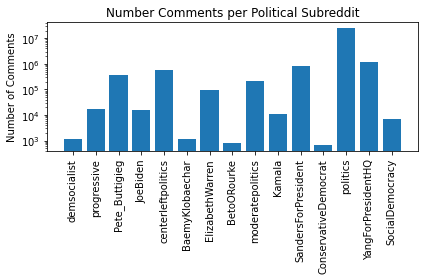

In [27]:
fig = plt.figure()
plt.yscale('log')
plt.title('Number Comments per Political Subreddit')

plt.ylabel('Number of Comments')
plt.bar(wdf["subreddit"],wdf["count"])
plt.xticks(rotation='vertical')
fig.tight_layout()

## Write Vocabularies and Training Data to File

In [2]:
# Create a temp context for the word and context vocabulary files (which get passed to the word2vecf script)
# temp_dir = tempfile.TemporaryDirectory()
import subprocess
import sys
import os
temp_dir = "/h/224/cameron/Political-Subreddit-Embedding/temp/"
subprocess.run("mkdir -p {}".format(temp_dir), shell=True)

CompletedProcess(args='mkdir -p /h/224/cameron/Political-Subreddit-Embedding/temp/', returncode=0)

In [3]:
# Create temp files
file_data = os.path.join(temp_dir, 'data.txt')
file_wv = os.path.join(temp_dir, 'wv.txt')
file_cv = os.path.join(temp_dir, 'cv.txt')

In [ ]:
print("Writing training data to {}...".format(file_data))
training_data.toPandas().to_csv(file_data, header=False, index=False, sep=' ')
training_data.unpersist()

In [ ]:
print("Writing word vocab data to {}...".format(file_wv))
word_vocabulary.toPandas().to_csv(file_wv, header=False, index=False, sep=' ')
word_vocabulary.unpersist()

In [ ]:
print("Writing context vocab data to {}...".format(file_cv))
context_vocabulary.toPandas().to_csv(file_cv, header=False, index=False, sep=' ')
context_vocabulary.unpersist()

## Train Embedding

In [4]:
from utils import generate_embedding, load_embedding

In [ ]:
# Word2vec parameters, using negative sampling
# -alpha 0.18 -negative 35 -sample 0.0043 -size 150
embedding_args = {
                     "param1": "sample", 
#                      "p1": 0.0043, 
                    "param2": "negative", 
#                      "p2": 35, 
                    "file_data": file_data , 
                    "file_wv": file_wv, 
                    "file_cv": file_cv,
                    "size": 150,
                    "alpha": 0.18
                 }
p1_vals = np.linspace(0.001,0.01,11)
p2_vals = np.linspace(15,95,11)
all_embeddings = [(p1,p2) for p1 in p1_vals for p2 in p2_vals]
embeddings = []
for p1,p2 in tqdm(all_embeddings):
    embeddings.append(generate_embedding(p1=p1,p2=p2,**embedding_args))
embedding

  1%|          | 1/121 [13:33<27:06:10, 813.09s/it]

In [5]:
subreddits, vectors = load_embedding(embedding)
vectors

,1,2,3,4,5,6,7,8,9,10,...,141,142,143,144,145,146,147,148,149,150
0,-0.048178,0.021482,-0.033970,-0.061168,-0.029943,0.090738,-0.060890,-0.064819,0.046365,-0.110363,...,-0.080529,0.009409,0.090371,0.160984,-0.012692,0.037296,-0.133719,-0.054398,0.045666,-0.094102
1,0.039633,-0.130123,0.047644,0.073585,0.089806,0.015975,-0.077038,-0.023020,0.097915,-0.093603,...,-0.003924,0.094406,-0.028855,0.182672,0.114283,0.046218,-0.122043,-0.027566,0.101160,-0.094482
2,0.014866,0.105574,-0.015800,-0.009825,0.059193,0.157330,-0.094050,-0.165119,0.077472,-0.076255,...,-0.101872,0.055519,0.001593,0.089291,0.035413,0.046253,-0.087247,0.085222,0.025805,-0.159948
3,0.051227,-0.011974,0.003561,0.047713,0.004941,-0.053547,-0.138880,0.075173,-0.014687,0.022192,...,-0.056815,0.006998,0.090546,0.055618,-0.003918,-0.102020,-0.056633,0.013987,-0.081270,-0.055979
4,-0.095111,0.053749,0.011059,-0.072698,-0.062629,-0.075457,-0.029677,0.017484,-0.016888,-0.004716,...,0.071732,0.082159,-0.182717,0.127624,0.015954,-0.206583,-0.084462,-0.089431,0.066405,-0.076050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,-0.023875,-0.024923,-0.013402,0.003846,0.006347,0.069092,-0.079145,-0.027321,0.018481,-0.095079,...,0.104024,0.098131,-0.065208,0.146092,0.105407,0.027191,-0.073014,-0.022048,-0.021949,-0.049449
1006,0.009682,-0.052802,0.037955,-0.115337,-0.053914,0.084777,-0.156884,-0.027475,-0.084624,-0.127756,...,0.039904,0.116992,-0.021720,0.167901,0.106617,0.094536,-0.032064,-0.040523,0.008024,-0.004132
1007,-0.007730,-0.040278,-0.072353,0.011064,0.006521,0.090017,-0.112426,-0.012652,-0.025386,-0.064218,...,0.048959,0.084410,-0.015494,0.219271,0.147901,0.078930,-0.101491,-0.111678,-0.004957,-0.069073
1008,0.017894,-0.040889,0.054302,0.020973,-0.067203,0.142831,-0.197403,-0.069740,-0.014712,-0.116652,...,-0.001153,0.058416,0.106178,0.163847,0.100974,0.032369,-0.143735,-0.036005,-0.009335,-0.056085


### Reduce to 3 dimensions

In [15]:
from sklearn.decomposition import PCA
# PCA Dim Reduction
pca =  PCA(n_components = 3)
three_dim =  pd.DataFrame(pca.fit_transform(vectors))

### Visualize Embedding

In [16]:
import plotly.express as px

In [17]:
political_subreddits = ["JoeBiden","Pete_Buttigieg","Kamala",
                        "SandersForPresident","BetoORourke","ElizabethWarren",
                        "BaemyKlobaechar","YangForPresidentHQ","politics","progressive",
                        "demsocialist","SocialDemocracy","centerleftpolitics",
                        "ConservativeDemocrat","moderatepolitics"]
three_dim["subreddit"] = subreddits
# three_dim = three_dim[three_dim["subreddit"].isin(political_subreddits)]
three_dim

,0,1,2,subreddit
0,0.119015,-0.011856,-0.167281,SquaredCircle
1,0.049838,0.111584,0.041391,AskReddit
2,0.164466,-0.189780,-0.007797,politics
3,-0.006120,0.193823,-0.146203,memes
4,-0.202914,0.005731,-0.054405,teenagers
...,...,...,...,...
1005,0.015508,-0.168764,0.107581,SocialDemocracy
1006,0.255026,-0.315456,-0.061325,BaemyKlobaechar
1007,-0.039142,-0.326228,0.093325,demsocialist
1008,0.157210,-0.266703,-0.081300,BetoORourke


In [18]:
fig = px.scatter_3d(three_dim, x=0, y=1, z=2,text="subreddit",opacity=0.7)
fig.write_html("visualizations/ALL_SUBS_3d_scatter.html")
fig.show()

### Reduce to 2 dimensions

In [21]:
# PCA Dim Reduction
pca =  PCA(n_components = 2)
two_dim =  pd.DataFrame(pca.fit_transform(vectors))
two_dim['subreddit'] = subreddits
two_dim = two_dim[two_dim["subreddit"].isin(political_subreddits)]
fig = px.scatter(two_dim, x=0, y=1,text="subreddit")
fig.write_html("visualizations/2d_scatter.html")
fig.show()